>>> PART 1: Setting up environment...
Mounted at /content/drive

>>> PART 2: Preparing data...
Data preparation complete.

>>> PART 3: Loading LSTM benchmark model...


LSTM model loaded successfully.

>>> PART 4: Rebuilding and retraining the Transformer model...
Starting Transformer model training... Please wait.
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 382ms/step - loss: 0.3425
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0355
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0191
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0144
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0141
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0104
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0089
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0088
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0080
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0078
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0087
Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - l

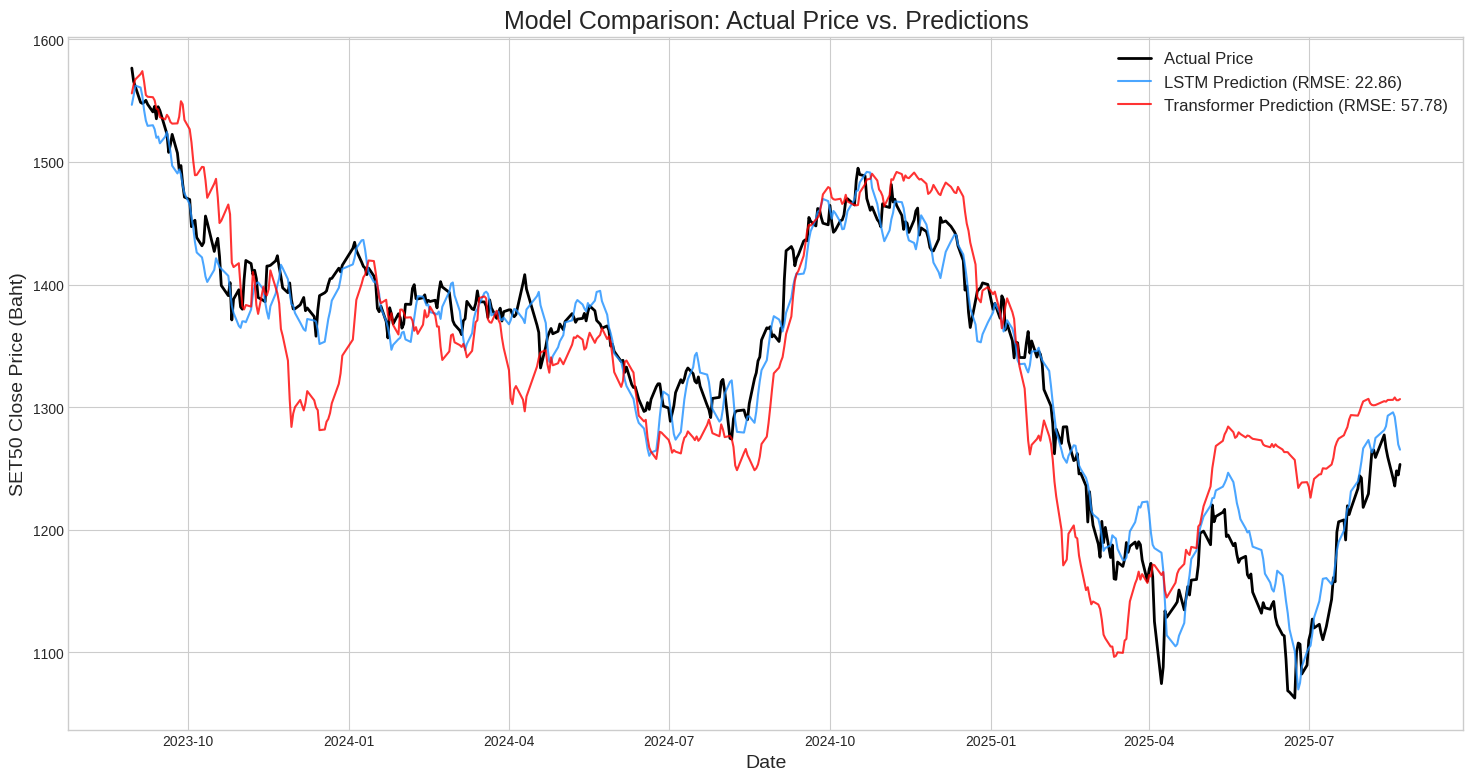

In [1]:
# ==============================================================================
# FINAL VERSION FOR NOTEBOOK 4: MODEL COMPARISON
# This script will load the LSTM model and retrain the Transformer model
# from scratch to bypass all loading errors.
# ==============================================================================

# --- PART 1: SETUP AND IMPORTS ---
print(">>> PART 1: Setting up environment...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- PART 2: DATA PREPARATION (Same as before) ---
print("\n>>> PART 2: Preparing data...")
# Load data
data_path = '/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/02_data/set50_processed_data.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)

# Scale and split data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
training_size = int(len(scaled_data) * 0.8)
time_step = 60
train_data = scaled_data[0:training_size, :]
test_data = scaled_data[training_size - time_step:, :]

# Windowing function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 3])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("Data preparation complete.")

# --- PART 3: LOAD THE LSTM MODEL (This part works fine) ---
print("\n>>> PART 3: Loading LSTM benchmark model...")
lstm_model_path = '/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/03_models/lstm_benchmark_model.h5'
lstm_model = tf.keras.models.load_model(lstm_model_path)
print("LSTM model loaded successfully.")

# --- PART 4: REBUILD AND RETRAIN THE TRANSFORMER MODEL ---
print("\n>>> PART 4: Rebuilding and retraining the Transformer model...")
# Transformer architecture functions
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # --- Attention Block (เหมือนเดิม) ---
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs) # Skip Connection ที่ 1

    # --- Feed Forward Block (แก้ไขตรงนี้) ---
    res = x  # <-- เพิ่ม: เก็บค่า x ก่อนเข้า FFN ไว้สำหรับ Skip Connection
    ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(inputs.shape[-1])])
    x = ffn(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(res + x) # <-- แก้ไข: ใช้ res ที่เก็บไว้มาบวก
    return x

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embedding = tf.keras.layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = x + pos_embedding
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# Build a new Transformer model instance
transformer_model = build_transformer_model(
    X_train.shape[1:], head_size=256, num_heads=4, ff_dim=4,
    num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25
)
transformer_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (this will take 5-15 minutes)
print("Starting Transformer model training... Please wait.")
transformer_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
print("Transformer model training complete.")

# --- PART 5: GENERATE PREDICTIONS & COMPARE RESULTS ---
print("\n>>> PART 5: Generating predictions and comparing results...")
# Generate predictions
lstm_predictions = lstm_model.predict(X_test)
transformer_predictions = transformer_model.predict(X_test)

# Inverse transform function
def inverse_transform_predictions(predictions, original_scaled_data):
    pred_full = np.zeros(shape=(len(predictions), original_scaled_data.shape[1]))
    pred_full[:, 3] = predictions.flatten()
    pred_inv = scaler.inverse_transform(pred_full)[:, 3]
    return pred_inv

lstm_pred_inv = inverse_transform_predictions(lstm_predictions, scaled_data)
transformer_pred_inv = inverse_transform_predictions(transformer_predictions, scaled_data)
actual_prices = df['Close'][-len(y_test):].values

# --- คำนวณค่า RMSE ของแต่ละโมเดล ---
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, lstm_pred_inv))
transformer_rmse = np.sqrt(mean_squared_error(actual_prices, transformer_pred_inv))

# --- สร้างตารางเปรียบเทียบด้วย Pandas DataFrame (ฉบับแก้ไข) ---
results_df = pd.DataFrame({
    'Model': ['LSTM (Benchmark)', 'Transformer (Upgrade)'],
    'Test RMSE (Baht)': [lstm_rmse, transformer_rmse]
})

# คำนวณ % การเปลี่ยนแปลงของ Error (ถ้าเป็น + คือแย่ลง, ถ้าเป็น - คือดีขึ้น)
change_in_error = (transformer_rmse - lstm_rmse) / lstm_rmse * 100
results_df['Change in Error (%)'] = ['-', f'{change_in_error:+.2f}%'] # :+.2f จะใส่เครื่องหมาย + หรือ - ให้เอง

print("--- Performance Comparison (Corrected) ---")
print(results_df)

# Qualitative Comparison (Plot)
print("\nGenerating comparison plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 9))
plt.title('Model Comparison: Actual Price vs. Predictions', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SET50 Close Price (Baht)', fontsize=14)
test_dates = df.index[-len(actual_prices):]
plt.plot(test_dates, actual_prices, label='Actual Price', color='black', linewidth=2)
plt.plot(test_dates, lstm_pred_inv, label=f'LSTM Prediction (RMSE: {lstm_rmse:.2f})', color='dodgerblue', alpha=0.8)
plt.plot(test_dates, transformer_pred_inv, label=f'Transformer Prediction (RMSE: {transformer_rmse:.2f})', color='red', alpha=0.8)
plt.legend(fontsize=12)
plt.show()

In [6]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a fully fixed, Colab-ready Notebook with the user's dataset and corrected pipeline
import nbformat as nbf
from textwrap import dedent
from pathlib import Path

nb = nbf.v4.new_notebook()
cells = []

#1) Title & Overview
cells.append(nbf.v4.new_markdown_cell(dedent("""
# SET50 Model Comparison (LSTM vs Transformer) — **Leakage‑Free, Val/EarlyStopping, Correct Target**
**Author:** Patchara (Pae) & ChatGPT (Senior AI Engineer)
**What’s fixed:**
- ✅ Fit `MinMaxScaler` **only on train** (no leakage)
- ✅ Use dynamic `target_idx = df.columns.get_loc('Close')` (no hard‑coded index)
- ✅ Correct pooling (`GlobalAveragePooling1D()`; channels_last)
- ✅ Add validation split, `EarlyStopping`, and `ReduceLROnPlateau`
- ✅ Time-series‑friendly split (val from the tail of train windows)
- ✅ Results table (RMSE, MAE, Directional Accuracy) + Plot

> **Tip:** Run on **Google Colab** (GPU optional). If using Colab, consider mounting Drive to save models.
""")))

# 2) Imports, Seeds, Utils
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 1: SETUP AND IMPORTS ---
print(">>> PART 1: Setting up environment...")

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, LSTM)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def set_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

set_seeds(42)

print("TensorFlow:", tf.__version__)
""")))

# 3) Optional Colab Drive Mount
cells.append(nbf.v4.new_code_cell(dedent("""
# --- OPTIONAL: Colab Drive Mount ---
# from google.colab import drive
# drive.mount('/content/drive')
# SAVE_DIR = "/content/drive/MyDrive/Thai_Quant_AI_Project/models"
# os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_DIR = "./models"
os.makedirs(SAVE_DIR, exist_ok=True)
""")))

# 4) Load Data (from /mnt/data path by default), set index, ensure numeric
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 2: DATA PREPARATION (Leakage-free) ---
print("\\n>>> PART 2: Preparing data...")

# If running locally in ChatGPT sandbox, this path exists. In Colab, upload the same CSV or change path.
data_path = "/mnt/data/set50_processed_data.csv"  # change to your path if needed
df = pd.read_csv(data_path, parse_dates=['Date'])
df = df.sort_values('Date').set_index('Date')

# Pick target column dynamically
target_col = 'Close'
assert target_col in df.columns, f"'{target_col}' not in columns: {list(df.columns)}"
target_idx = df.columns.get_loc(target_col)

display(df.head(3))
print("Rows:", len(df), "| Cols:", len(df.columns), "| target_idx:", target_idx)
""")))

# 5) Train/Test Split (time-based), Scale with train-only, create windows
cells.append(nbf.v4.new_code_cell(dedent("""
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].copy()
df_test  = df.iloc[train_size:].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)   # fit only on train
test_scaled  = scaler.transform(df_test)

time_step = 60

def create_dataset(dataset, time_step, target_idx):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, target_idx])
    return np.array(X), np.array(y)

# For test, prepend tail of train to ensure enough history
test_stacked = np.vstack([train_scaled[-time_step:], test_scaled])

X_train_full, y_train_full = create_dataset(train_scaled, time_step, target_idx)
X_test, y_test = create_dataset(test_stacked, time_step, target_idx)

# Time-series friendly validation from the tail of train windows
val_frac = 0.15
val_len = max(1, int(len(X_train_full) * val_frac))
X_train, y_train = X_train_full[:-val_len], y_train_full[:-val_len]
X_val, y_val     = X_train_full[-val_len:], y_train_full[-val_len:]

print("Train windows:", X_train.shape, "| Val windows:", X_val.shape, "| Test windows:", X_test.shape)
""")))

# 6) LSTM Baseline
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 3: LSTM Baseline ---
def build_lstm_model(input_shape, hidden=64, dropout=0.2):
    inputs = Input(shape=input_shape)
    x = LSTM(hidden, return_sequences=False)(inputs)
    x = Dropout(dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

lstm_model = build_lstm_model(X_train.shape[1:], hidden=64, dropout=0.2)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

print("Training LSTM... (this may take a few minutes)")
hist_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=64, verbose=1, callbacks=callbacks
)

# Optional: save model
lstm_path = os.path.join(SAVE_DIR, "lstm_benchmark_model.h5")
lstm_model.save(lstm_path)
print("Saved:", lstm_path)
""")))

# 7) Transformer Model (corrected)
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 4: Transformer (Corrected) ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    # Self-attention + residual
    attn_out = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(attn_out)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    # Feed-forward + residual
    ffn_in = x
    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1])  # project back to feature dim
    ])
    x = ffn(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(ffn_in + x)
    return x

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128,
                            num_transformer_blocks=3, mlp_units=[128], dropout=0.2, mlp_dropout=0.3):
    inputs = Input(shape=input_shape)  # (time, features)

    # Learnable positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embedding = tf.keras.layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embedding  # broadcast add

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Correct pooling for (batch, time, features)
    x = GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

tr_model = build_transformer_model(X_train.shape[1:], head_size=64, num_heads=4, ff_dim=128,
                                   num_transformer_blocks=3, mlp_units=[128], dropout=0.2, mlp_dropout=0.3)
tr_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

print("Training Transformer... (this may take a few minutes)")
hist_tr = tr_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=64, verbose=1, callbacks=callbacks
)

tr_path = os.path.join(SAVE_DIR, "transformer_upgrade_model.h5")
tr_model.save(tr_path)
print("Saved:", tr_path)
""")))

# 8) Inference, inverse transform, metrics, plot
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 5: Evaluation & Comparison ---
def inverse_transform_predictions(predictions, scaler, n_features, target_idx):
    tmp = np.zeros((len(predictions), n_features))
    tmp[:, target_idx] = predictions.flatten()
    inv = scaler.inverse_transform(tmp)[:, target_idx]
    return inv

# Predict
lstm_pred = lstm_model.predict(X_test, verbose=0)
tr_pred   = tr_model.predict(X_test, verbose=0)

lstm_pred_inv = inverse_transform_predictions(lstm_pred, scaler, df.shape[1], target_idx)
tr_pred_inv   = inverse_transform_predictions(tr_pred,   scaler, df.shape[1], target_idx)

# Actuals (align with test windows)
actual_prices = df.iloc[train_size + 1 + time_step : train_size + 1 + time_step + len(lstm_pred_inv)][target_col].values

# Metrics
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(mean_absolute_error(y, yhat))
def dir_acc(y, yhat):
    # directional accuracy vs previous actual (sign of change)
    dy  = np.sign(np.diff(y))
    dyh = np.sign(np.diff(yhat))
    return float((dy == dyh).mean()) if len(dy) == len(dyh) and len(dy) > 0 else np.nan

metrics = pd.DataFrame([
    {
        "Model": "LSTM (Benchmark)",
        "RMSE (Baht)": rmse(actual_prices, lstm_pred_inv),
        "MAE (Baht)":  mae(actual_prices, lstm_pred_inv),
        "Directional Acc.": dir_acc(actual_prices, lstm_pred_inv)
    },
    {
        "Model": "Transformer (Upgrade)",
        "RMSE (Baht)": rmse(actual_prices, tr_pred_inv),
        "MAE (Baht)":  mae(actual_prices, tr_pred_inv),
        "Directional Acc.": dir_acc(actual_prices, tr_pred_inv)
    }
])

# Relative change vs LSTM
delta_rmse = (metrics.loc[1,"RMSE (Baht)"] - metrics.loc[0,"RMSE (Baht)"]) / metrics.loc[0,"RMSE (Baht)"] * 100.0
metrics["Δ Error vs LSTM (%)"] = ["-", f"{delta_rmse:+.2f}%"]

print("\\n--- Performance Comparison ---")
print(metrics)

# Plot (Matplotlib only; no seaborn; single figure; no explicit colors)
print("\\nGenerating comparison plot...")
test_dates = df.iloc[train_size + 1 + time_step : train_size + 1 + time_step + len(actual_prices)].index
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual_prices, label="Actual Close", linewidth=2)
plt.plot(test_dates, lstm_pred_inv, label="LSTM Prediction")
plt.plot(test_dates, tr_pred_inv, label="Transformer Prediction")
plt.title("Model Comparison: Actual Price vs Predictions")
plt.xlabel("Date"); plt.ylabel("SET50 Close (Baht)")
plt.legend(); plt.tight_layout(); plt.show()
""")))

# 9) Save results & notes
cells.append(nbf.v4.new_code_cell(dedent("""
# --- PART 6: Save results (optional) ---
metrics_path = os.path.join(SAVE_DIR, "model_comparison_metrics.csv")
pd.DataFrame(metrics).to_csv(metrics_path, index=False)
print("Saved metrics to:", metrics_path)
""")))

# Attach cells to notebook
nb['cells'] = cells

# Save the notebook
out_path = Path("/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/03_models/SET50_Model_Comparison_Fixed.ipynb")
out_path.write_text(nbf.writes(nb), encoding="utf-8")

print("Notebook created at:", str(out_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Notebook created at: /content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/03_models/SET50_Model_Comparison_Fixed.ipynb
